In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

imputedDataset = pd.read_stata("/Users/burke/Documents/microsim/microsim/data/fullyImputedDataset.dta")

#imputedDataset = pd.read_stata("/Users/burke/Documents/research/bpCog/microsim/microsim/data/fullyImputedDataset.dta")
imputedDataset.head()

,level_0,index,WTINT2YR,a1c,age,antiHypertensive,bmi,diedBy2015,gender,hdl,ldl,monthsToDeath,monthsToDeath2,otherLipidLowering,selfReportCurrentHtnMed,selfReportHtn,selfReportMI,selfReportMIAge,selfReportStroke,selfReportStrokeAge,statin,timeInUS,tot_chol,trig,ucod,waist,weight,year,anyPhysicalActivity,meanSBP,meanDBP,alcoholPerWeek,completedInterview,missingSBP,htn3,htn4,meanSBP3,jnc8,raceEthnicity,smokingStatus,education
0,0,0,102641.406474,5.1,22.0,0.0,23.3,0,1.0,41.0,110.0,61.0,61.0,0.0,0,0,0,NaN,0,NaN,0.0,NaN,168.0,84.0,0,81.0,69.2,2011,0,110.666667,74.666667,0.0,1,0,0,0,110.666667,0,3,0,3
1,1,3,127351.373299,4.9,44.0,0.0,23.2,0,2.0,28.0,151.0,41.0,40.0,0.0,0,0,0,NaN,0,NaN,0.0,NaN,190.0,56.0,0,80.1,67.2,2011,1,118.000000,60.000000,7.0,1,0,0,0,118.000000,0,3,0,4
2,2,8,14391.778470,5.4,21.0,0.0,20.1,0,1.0,43.0,73.0,53.0,52.0,0.0,0,0,0,NaN,0,NaN,0.0,NaN,132.0,78.0,0,69.6,54.6,2011,0,124.666667,78.000000,14.0,1,0,0,0,124.666667,0,5,0,3
3,3,11,26960.774346,5.6,43.0,0.0,33.3,0,2.0,73.0,68.0,45.0,43.0,0.0,0,0,0,NaN,0,NaN,0.0,NaN,169.0,141.0,0,120.4,98.6,2011,0,102.000000,71.333333,21.0,1,0,0,0,102.000000,0,4,2,3
4,4,13,24912.668432,5.0,80.0,1.0,33.9,1,1.0,54.0,132.0,21.0,21.0,0.0,1,1,0,NaN,0,NaN,0.0,NaN,203.0,110.0,100,116.5,95.8,2011,0,98.000000,61.333333,7.0,1,0,1,1,97.000000,0,3,0,5


# Now the goal is to see what the risk factors would look like for the NHANES 1999 population, if we advanced them to 2015

For the NHANES side of things, we want the blood pressure distribution in 2015 that excludes people that moved into the coutnry in the prior 16 years (since 1999). 

For the simulation side of things, we'll need to load the mortality data so that we can take out the poeple that died between 1999 and 2015.

<AxesSubplot:>

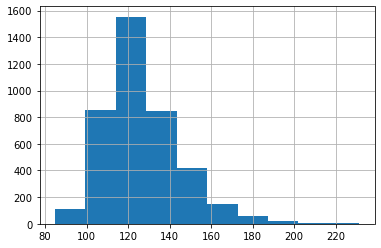

In [2]:
%matplotlib inline
startYear = 1999
endYear = 2015
totalYears = endYear - startYear

noRecentUSInmigration = imputedDataset.loc[~imputedDataset.timeInUS.isin([1,2,3])]
recentCrossSectionOfNonImmigrants = noRecentUSInmigration.loc[noRecentUSInmigration.year==endYear]
# the simulated cohort starts in 1999 and then ages people forward ...so, teh youngest age is 18 + the number of years advanced
recentCrossSectionOfNonImmigrants = recentCrossSectionOfNonImmigrants.loc[recentCrossSectionOfNonImmigrants.age > 18 +totalYears]
recentCrossSectionOfNonImmigrants = recentCrossSectionOfNonImmigrants.sample(n=len(recentCrossSectionOfNonImmigrants), weights=recentCrossSectionOfNonImmigrants.WTINT2YR, replace=True)
recentCrossSectionOfNonImmigrants.meanSBP.hist()

In [3]:
earlyEndYear = 2001
earlyTotalYears = earlyEndYear - startYear

earlyCrossSectionOfNonImmigrants = imputedDataset.loc[imputedDataset.year==earlyEndYear]
# here we just need to throw out the very young people for comparisons
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.loc[earlyCrossSectionOfNonImmigrants.age > 18 + earlyTotalYears]
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.sample(n=len(earlyCrossSectionOfNonImmigrants), weights=earlyCrossSectionOfNonImmigrants.WTINT2YR, replace=True)

print (earlyCrossSectionOfNonImmigrants.meanSBP.describe())

count    5306.000000
mean      123.290175
std        19.254617
min        82.666667
25%       110.666667
50%       120.000000
75%       132.000000
max       229.333333
Name: meanSBP, dtype: float64


# Run a simple simulation with the cohort models (default) starting in 1999 as a comparator

In [6]:
import os
os.chdir("/Users/burke/Documents/microsim")
from microsim.population import NHANESDirectSamplePopulation

pop = NHANESDirectSamplePopulation(n=250000, year=1999)
pop.advance_vectorized(totalYears)


(         age  baseAge  gender  raceEthnicity  black         sbp        dbp  \
 1       56.0     40.0       1              5  False  122.888633  85.267303   
 3       72.0     56.0       2              3  False  108.625969  62.559733   
 4       43.0     27.0       2              4   True  123.007330  88.027841   
 5       37.0     21.0       1              1  False  114.451171  85.591665   
 6       76.0     60.0       1              3  False  135.820828  70.868075   
 ...      ...      ...     ...            ...    ...         ...        ...   
 249993  57.0     41.0       2              3  False  132.728818  82.332651   
 249995  75.0     59.0       1              3  False  153.387673  89.831847   
 249996  74.0     58.0       2              3  False  131.935363  72.344931   
 249997  45.0     29.0       2              3  False  123.807111  84.523291   
 249999  68.0     52.0       2              3  False  120.810602  69.620183   
 
              a1c  current_diabetes        hdl    

### Compare SBPs between teh simluation and between NHANES

NHANES SBPS
count    4022.000000
mean      126.610061
std        18.252483
min        84.666667
25%       114.000000
50%       124.000000
75%       136.000000
max       231.333333
Name: meanSBP, dtype: float64
Simulation SBPs
: count    217990.000000
mean        123.341749
std          15.809128
min          74.116899
25%         112.305244
50%         121.244705
75%         131.412590
max         216.530602
dtype: float64
NHANES SBPS
count    4022.000000
mean       71.578982
std        10.943833
min        40.000000
25%        64.000000
50%        71.333333
75%        78.666667
max       124.000000
Name: meanDBP, dtype: float64
Simulation SBPs
: count    217990.000000
mean         78.710288
std           9.198991
min          45.079246
25%          72.455994
50%          78.505748
75%          84.644627
max         132.315708
dtype: float64
NHANES SBPS
count    4022.000000
mean        5.826778
std         1.055336
min         4.000000
25%         5.300000
50%         5.600000
75%     

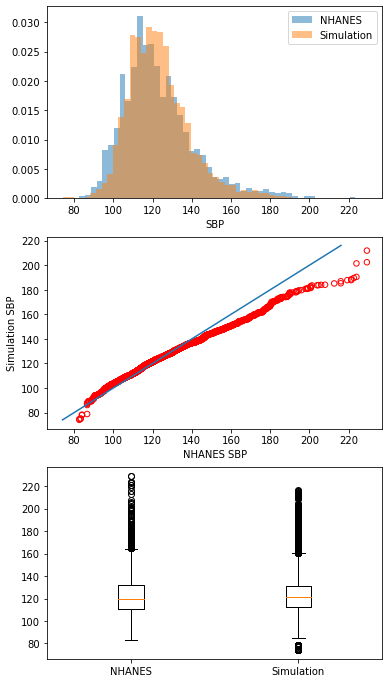

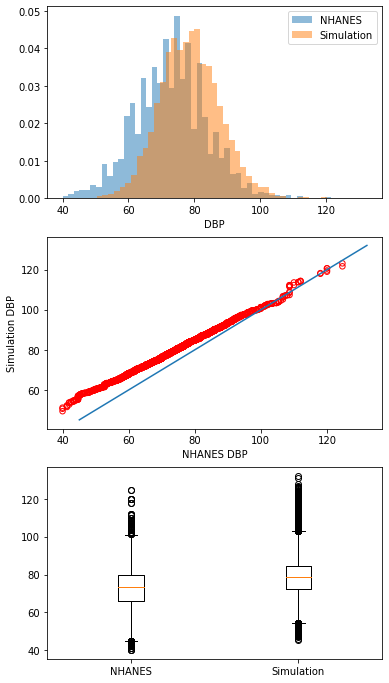

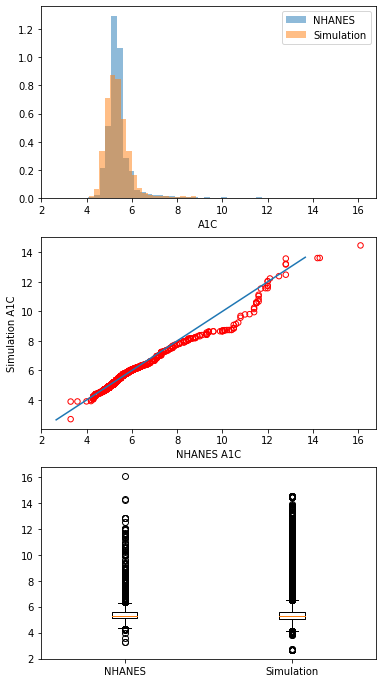

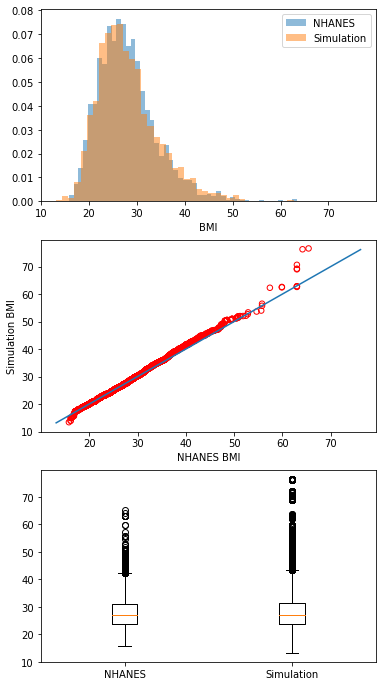

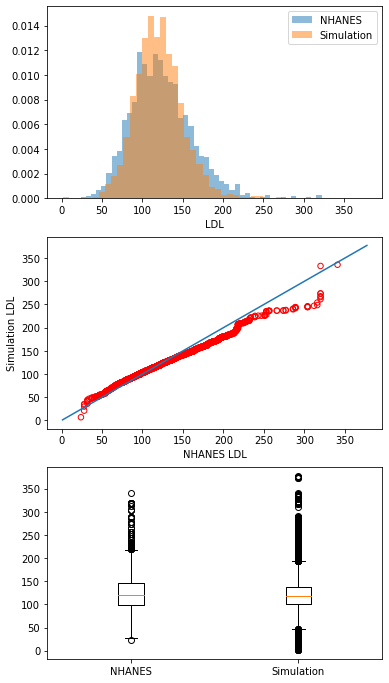

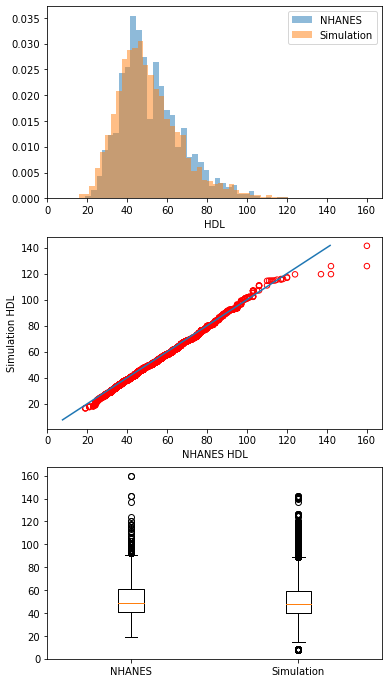

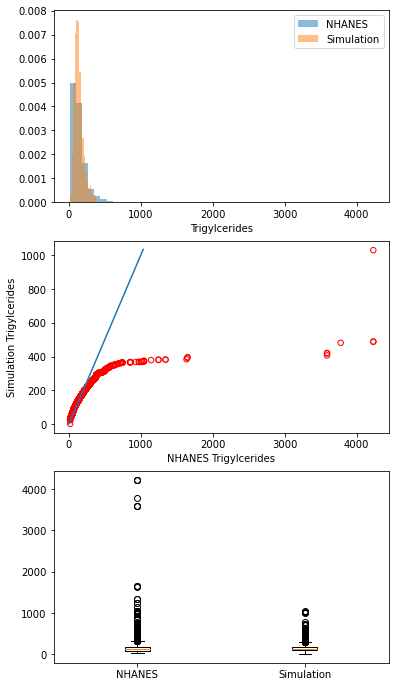

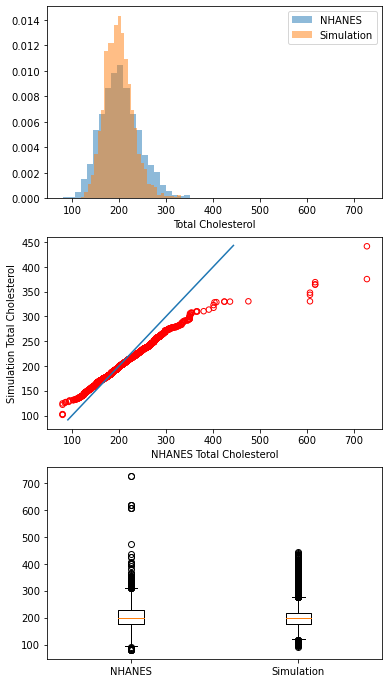

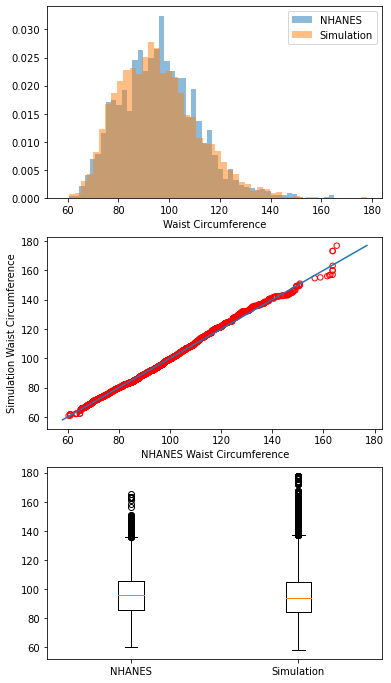

In [9]:
def addHistToAxis(attributeName, dfName, label, personAttributes, ax):
    ax.set_xlabel(label)
    ax.hist(earlyCrossSectionOfNonImmigrants[dfName], alpha=0.5, density=True, bins=50, label="NHANES")
    ax.hist(personAttributes, alpha=0.5, density=True, bins=50, label="Simulation")
    ax.legend()


def plotComparisonFigure(attributeName, dfName, label):

    personAttributes = pd.Series([ getattr(person, attributeName)[-1] for person in pop._people if not person.diedBy2015])


    fig, (ax1, ax2, ax3) = plt.subplots(3)

    fig.set_size_inches(6, 12)
    addHistToAxis(attributeName, dfName, label, personAttributes, ax1)
    print ("NHANES SBPS\n" + str(recentCrossSectionOfNonImmigrants[dfName].describe()))
    print("Simulation SBPs\n: " + str(personAttributes.describe()))
    ax2.scatter(earlyCrossSectionOfNonImmigrants[dfName].sort_values(), 
         personAttributes.sample(n=len(earlyCrossSectionOfNonImmigrants)).sort_values(), s=30, facecolors='none', edgecolors='r')
    ax2.set_ylabel(f"Simulation {label}")
    ax2.set_xlabel(f"NHANES {label}")
    plotRange = np.arange(personAttributes.min(),personAttributes.max())
    ax2.plot(plotRange, plotRange)

    ax3.boxplot([earlyCrossSectionOfNonImmigrants[dfName], personAttributes], labels=['NHANES', 'Simulation'])
    ax3.set_xlabel

    os.chdir("/Users/burke/Documents/microsimPrimaryAnalyses/figures/")
    plt.savefig(label + '.png')
    return fig, ax1, ax2, ax3

figureDescriptions = [('_sbp', 'meanSBP', 'SBP'), ('_dbp', 'meanDBP', 'DBP'),('_a1c', 'a1c', 'A1C'),
                     ('_bmi', 'bmi', 'BMI'), ('_ldl', 'ldl', 'LDL'), ('_hdl', 'hdl', 'HDL'),
                     ('_trig', 'trig', 'Trigylcerides'), ('_totChol', 'tot_chol', 'Total Cholesterol'),
                     ('_waist', 'waist', 'Waist Circumference')]

figs = []
hists = []
scatters = []
boxes = []

def saveFig(ax, fileName):
    fig = plt.savefig(fileName)


for desc in figureDescriptions:
    fig, hist, scatter, box = plotComparisonFigure(*desc)
    figs.append(fig)
    hists.append(hist)
    scatters.append(scatter)
    boxes.append(box)    
    saveFig(hist, desc[0] + "Hist.png")
    saveFig(scatter, desc[0] + "Scatter.png")
    saveFig(box, desc[0] + "Box.png")

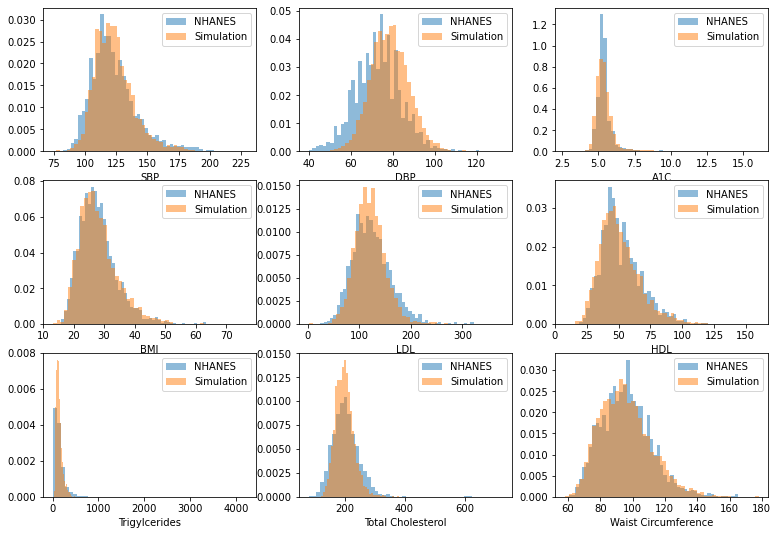

In [10]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(13, 9)


row = 0
col = 0
for desc in figureDescriptions:
    personAttributes = pd.Series([ getattr(person, desc[0])[-1] for person in pop._people if not person.diedBy2015])
    addHistToAxis(*desc, personAttributes, axs[row, col])
    if (col+1) % 3 is 0:
        col=0
        row+= 1
    else:
        col+=1
    
plt.savefig('compositeRiskFactorHistogram.png')

In [16]:
3 % 3

0

In [75]:
hists[0]

In [76]:
fig.axes[0]

In [63]:
earlyCrossSectionOfNonImmigrants.head()

,index,WTINT2YR,a1c,age,antiHypertensive,bmi,diedBy2015,gender,hdl,ldl,monthsToDeath,monthsToDeath2,otherLipidLowering,selfReportMI,selfReportMIAge,selfReportStroke,selfReportStrokeAge,statin,timeInUS,tot_chol,trig,ucod,waist,weight,year,anyPhysicalActivity,meanSBP,meanDBP,alcoholPerWeek,raceEthnicity,smokingStatus,education
33394,33394,25845.884333,5.3,73.0,0.0,22.47,1.000000e+00,1.0,57.0,73.0,111.0,110.0,0.0,0,NaN,0,NaN,0.0,NaN,166.0,89.0,3,85.5,69.2,2001,1,138.666667,64.666667,7.0,3,1,5
30268,30268,85963.804502,4.8,39.0,1.0,37.15,5.397605e-79,2.0,44.0,113.0,131.0,130.0,0.0,0,NaN,0,NaN,0.0,NaN,208.0,91.0,0,101.3,96.9,2001,1,125.333333,89.333333,0.0,3,0,5
33531,33531,74874.410185,5.5,33.0,0.0,26.89,5.397605e-79,2.0,44.0,104.0,115.0,115.0,0.0,0,NaN,0,NaN,0.0,NaN,167.0,106.0,0,88.5,69.8,2001,1,113.333333,70.000000,7.0,3,0,3
34330,34330,47803.159784,5.4,21.0,0.0,29.94,5.397605e-79,1.0,43.0,111.0,110.0,109.0,0.0,0,NaN,0,NaN,0.0,NaN,179.0,125.0,0,99.6,98.4,2001,1,108.666667,68.000000,84.0,3,0,4
29447,29447,35236.674324,5.4,45.0,1.0,27.53,5.397605e-79,1.0,42.0,136.0,110.0,110.0,0.0,0,NaN,0,NaN,0.0,NaN,219.0,140.0,0,102.5,84.4,2001,1,124.666667,68.666667,14.0,3,2,3


Summary — SBP pressure predictions afgter 11 years look quite good. Mean is very close to the NHANES mean, variance is slightly reduced and there is slight underprediction on trhe very high end, but its not awful.

In fact, I think its close enough that I wouldn't recalibrate. Instead, I think we can see how we do when we add treatmetn...and if it holds up ok, then I think we're done and won't need recalibration.

meanSBP


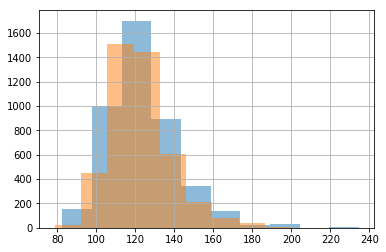

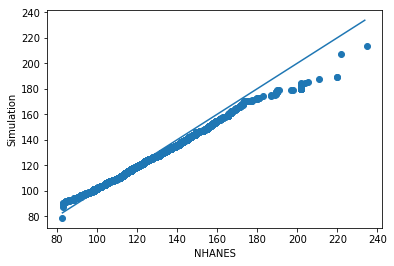

meanDBP


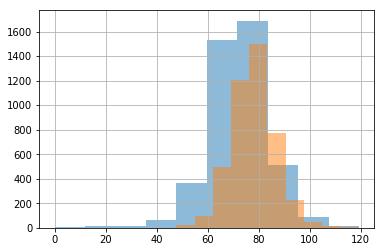

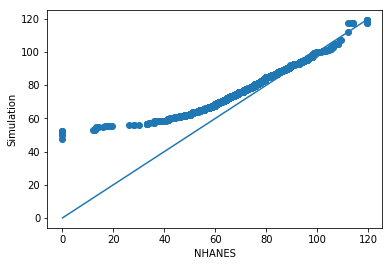

bmi


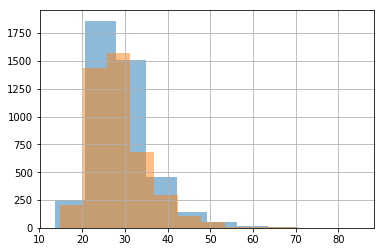

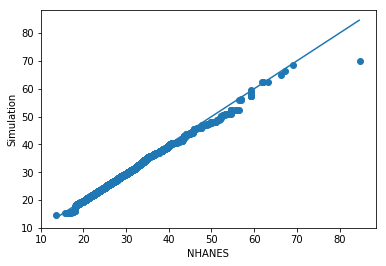

ldl


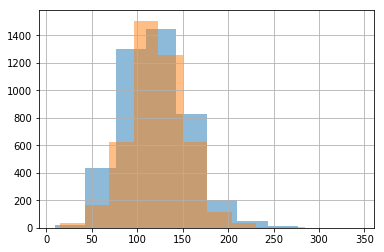

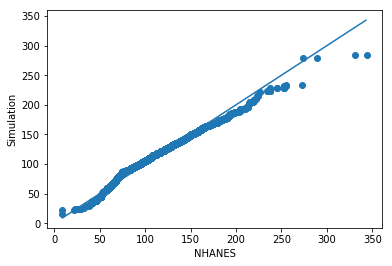

hdl


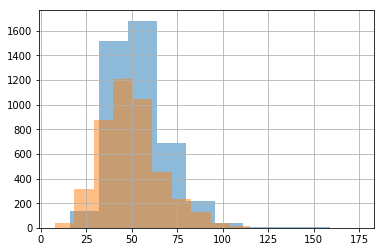

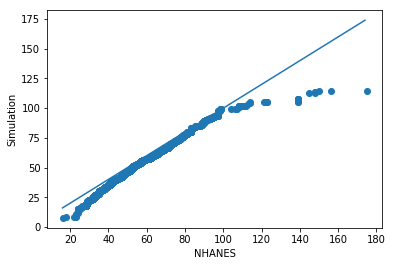

a1c


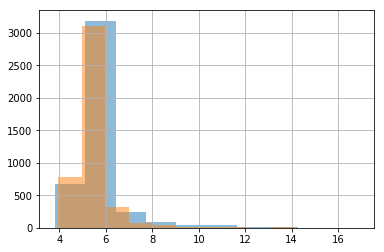

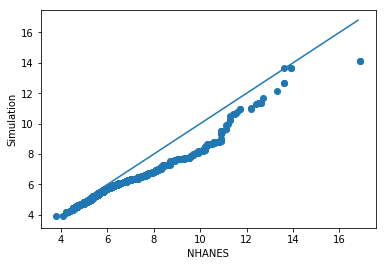

trig


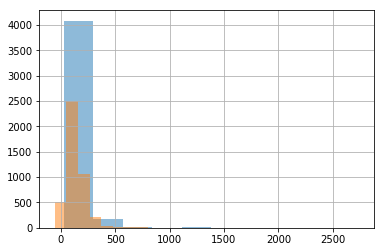

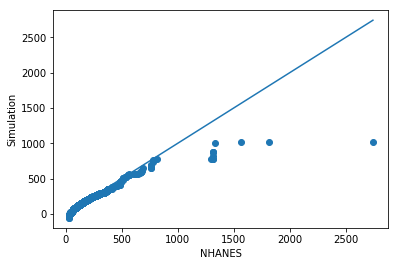

In [7]:
riskFactors = [("meanSBP", "sbp"), ("meanDBP", "dbp"), ("bmi", "bmi"), ("ldl", "ldl"), ("hdl", "hdl"), ("a1c", "a1c"), ("trig", "trig")]

def getRiskFactors(nhanesName, simName):
    nhanes = recentCrossSectionOfNonImmigrants[nhanesName]
    sim = [ getattr(person, "_" + simName)[-1] for person in pop._people if not person.diedBy2011]
    return (nhanes, pd.Series(sim))
    
for riskFactorTuple in riskFactors:
    print(riskFactorTuple[0])
    nhanes, sim = getRiskFactors(riskFactorTuple[0], riskFactorTuple[1])
    nhanes.hist(alpha=0.5)
    sim.hist(alpha=0.5)
    plt.show()
    
    plt.scatter(nhanes.sort_values(), 
     sim.sample(n=len(recentCrossSectionOfNonImmigrants)).sort_values())
    plt.plot(np.arange(nhanes.min(),nhanes.max()), np.arange(nhanes.min(), nhanes.max()))
    plt.xlabel("NHANES")
    plt.ylabel("Simulation")
    plt.show()
